# Supervised Learning


This hands-on session is split into **2 parts**: a (very) short one with synthetic data to experiment a bit with SVM models, and a longer one aiming at predicting avalanches from wheater data (based on real data).




In [1]:
# Viz
import matplotlib.pyplot as plt


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing
from sklearn.datasets import make_blobs

import pandas as pd
import numpy as np



# Preliminaries on synthetic data

The goal here is to experience the examples seen during the lecture, concerning the robustness to outliers.

Below is a synthetic dataset, and you'll learn an SVM classifier and see what happens when having outliers.

In [4]:

# make 2-class dataset for classification
centers = [[-10, 0], [10, 0]]
x, y = make_blobs(n_samples=100, centers=centers, random_state=40)


# Add some biasing points
center_noise = [[10, 4], [-10, -4]]
x_noise, y_noise = make_blobs(n_samples=3, centers=center_noise, random_state=4, cluster_std=0.1)
xbiased = np.concatenate((x,x_noise))
ybiased = np.concatenate((y,y_noise))


Visualize the dataset with a scatter plot, and plot the margins with various soft margin strenghts. The soft margins strengths in the ```SVC``` function are controlled with the parameter ```C```. Try values in the range ```[0,1]``` and report a value of strenght that looks like this figure :  ![title](svm.png) 

In [ ]:


# Function for plotting dataset, decision rule and margins of a SVM classifier
def plot_svm(clf,x,y):
    # Adapted from https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-20, 20)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
    # 2-d.
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(1, figsize=(4, 3))
    plt.clf()
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")
    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
        cmap=plt.cm.get_cmap("RdBu"),
    )
    plt.scatter(
        xbiased[:, 0], xbiased[:, 1], c=ybiased*0.5, zorder=10, cmap=plt.cm.get_cmap("brg"), edgecolors="k"
    )
    plt.axis("tight")
    x_min = -20
    x_max = 20
    y_min = -10
    y_max = 10
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    
    # Put the result into a contour plot
    plt.contourf(XX, YY, Z, cmap=plt.cm.get_cmap("brg"), alpha=0.5, linestyles=["-"])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    
    
# fit the model
penalties  = np.linspace(0.001,1,10)
for penalty in penalties:
    clf = svm.SVC(kernel="linear", C=penalty)
    clf.fit(xbiased, ybiased)
    plot_svm(clf,xbiased,ybiased)
    

What is the benefit of setting this penalty when fitting the model? How do you quantify the robustness of the decision rule?

setting penalty close to 0 avoid the model to be modified because of outliers, which allows more robustness. So with setting a penalty, we can choose wether we use hard margins or soft margins. It can be useful if we have a lot of noisy points.

C quantify the robustness of the decision rule. When C is close to 0, it is more robust.

Answer:

To what model parameter the following figure corresponds to:  ![title](svm0.png) 
    
What is the name of this model?
#TO COMPLETE
 

C = 1.0 .
It's a SVM model with hard margins.

# Avalanche dataset

We now focus on real data. The goal is is to predict an avalanche from weather data. The dataset is a real dataset which has been built by Ensimag students in 2019, through a "Projet de spécialité". Thanks to their work, we can now enjoy predicting avalanches for free.

They scrapped data from different sources, and only retain here the part of the data related to cross-country ski-related avalanches.

We will use the following descriptors (names should be explicit enough, given that dens means density and  rad, radiation):

`"6am_temp","16pm_temp","precip","snow_fall","snow_dens","snow_depth","solar_rad"`


In [ ]:
data = pd.read_csv("avalanche_data.csv", header = 0)

# Balance the labels (as many 1 and 0) -> we drop many non-avalanche events
balanced_data = data[0:2448].sample(frac=1).to_numpy()

header = ["id","avalanche","data_source","orientation","date","long","lat","6am_temp","16pm_temp","precip","snow_fall","snow_dens","snow_depth","solar_rad"
]

# Data descriptors
raw_data = balanced_data[:, 7:14].astype(float)
# normalize the data using preprocessing.StandardScaler() call
x = preprocessing.StandardScaler().fit_transform(raw_data)
kept_headers = header[7:14]
y = balanced_data[:,1].astype(int) # y=1 means avalanche, y=0 means no avalanche




Take a look at the data: make a PCA, colored by class (avalanche or not). Is there a chance that we can classify our data?


In [ ]:
pca = PCA(n_components=2)
lower_dim_data = pca.fit_transform(x)
plt.clf()
plt.scatter(lower_dim_data[:,0],lower_dim_data[:,1],c=y) # color is y
plt.show()




Please comment on the structure of the data: will it be easy to predict avalanches or not? Why?

It is difficult to predict avalanches because of the noise.

## Classification

### SVM
Learn a simple classifier: an SVM for instance. Show some useful statistics on the performances.



In [55]:
from sklearn.metrics import classification_report
# Create a classifier: a support vector classified
svm_avalanche = svm.SVC()

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, shuffle=True
)

# Learn the digits on the train subset
model = svm_avalanche.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted_svm = model.predict(X_test)

print(classification_report(y_test, predicted_svm))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       624
           1       0.85      0.80      0.82       600

    accuracy                           0.83      1224
   macro avg       0.83      0.83      0.83      1224
weighted avg       0.83      0.83      0.83      1224



Now you can optimize your classifier by changing the kernel, the `gamma` parameter of the RBF (Gaussian) kernel, as well as the soft margins. Find optimal parameters that optimize the performances on the validation set.

In [83]:
from sklearn.metrics import precision_score

# Create a classifier: a support vector classifier
svm_avalanche = svm.SVC( gamma = 1.0, C=5.0)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, shuffle=True
)
    

# Learn the digits on the train subset
model = svm_avalanche.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted_svm = model.predict(X_test)

print(classification_report(y_test, predicted_svm))



              precision    recall  f1-score   support

           0       0.87      0.90      0.89       634
           1       0.89      0.86      0.87       590

    accuracy                           0.88      1224
   macro avg       0.88      0.88      0.88      1224
weighted avg       0.88      0.88      0.88      1224



### Interpretable models

We want to get a bit of insights of why there are avalanches, so we are going to use decision trees/random forest.

#### Decision tree

Make a [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with few leaves (e.g. 3) so that we can interpret easily the decisions.


In [87]:
from sklearn.metrics import accuracy_score


tree_avalanche = DecisionTreeClassifier(max_leaf_nodes=3)
tree_avalanche.fit(X_train, y_train)
predicted_tree = tree_avalanche.predict(X_test)
accuracy_tree_test = accuracy_score(y_test, predicted_tree)
print(f"Accuracy on test set : { accuracy_tree_test}")

predicted_train_tree = tree_avalanche.predict(X_train)
accuracy_tree_train = accuracy_score(y_train, predicted_train_tree)
print(f"Accuracy on train set : { accuracy_tree_train}")

Accuracy on test set : 0.8202614379084967
Accuracy on train set : 0.8259803921568627


The good thing with decision tree is that we can visualize the decisions. Use the command `tree.plot_tree`, setting the flag `filled=True` for more readability.

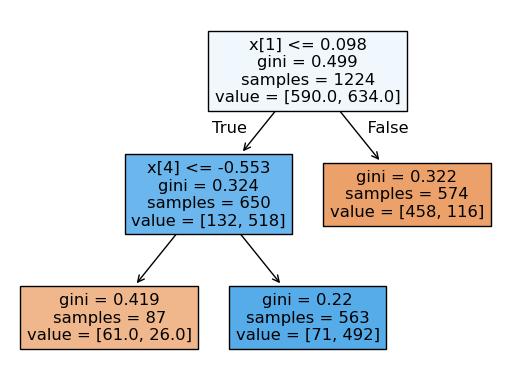

In [90]:
tree.plot_tree(tree_avalanche, filled=True)
plt.show()

Interpret the decision in terms of what it means physically, by matching the decision indicies with the headers (contained in the var `kept_headers`).

Answer:

If we want to increase the accuracy, we will have to make more splits... which is an issue as pointed out in the lectures. Verify this fact by yourself by monitoring the difference of accuracy between the train and validation set. When does it overfit?


In [ ]:
accuracy_train = list()
accuracy_test = list()

leaves =#TO COMPLETE (1 expression)

for nb_leaf in leaves:
    tree_avalanche = DecisionTreeClassifier(max_leaf_nodes=nb_leaf,#TO COMPLETE (1 expression)
#TO COMPLETE
    predicted_tree_validation =#TO COMPLETE (1 expression)
    predicted_tree_train =#TO COMPLETE (1 expression)
    accuracy_test +=#TO COMPLETE (1 expression)
    accuracy_train +=#TO COMPLETE (1 expression)
    
    

plt.clf()
plt.plot(leaves,accuracy_train,leaves,accuracy_test)
plt.show()

Answer:


#### Random forest

We switch to [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to see if we can get better accuracy without overfitting. Give a reason why RF are less prone to overfitting:

Answer:

In [ ]:

accuracy_train = list()
accuracy_test = list()

leaves =#TO COMPLETE (1 expression)

for nb_leaf in leaves:
    rf_avalanche = RandomForestClassifier(max_leaf_nodes=nb_leaf,#TO COMPLETE (1 expression)
#TO COMPLETE
    predicted_rf_validation =#TO COMPLETE (1 expression)
    predicted_rf_train =#TO COMPLETE (1 expression)
    accuracy_test +=#TO COMPLETE (1 expression)
    accuracy_train +=#TO COMPLETE (1 expression)
    
    

plt.clf()
plt.plot(leaves,accuracy_train,leaves,accuracy_test)
plt.show()

Comment on your results:

We cannot anymore visualize the tree, but we can **check the feature importance**. Take a look at the attribute `feature_importances_` of your random forest. What is the meaning of these numbers? Which feature look the most important?

In [ ]:
#TO COMPLETE
 